In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [3]:
from mmctools.helper_functions import covariance, w_s #Ts_to_Tv
from mmctools.plotting import plot_timehistory_at_height, plot_profile

# TTU tower measured heat flux / stability
written by Eliot Quon <eliot.quon@nrel.gov>

Estimate stability and calculate heat flux using 1-Hz data from `process_TTU_tower.ipynb`

In [4]:
towerdata = 'data/TTU_tilt_corrected_20131108-09.csv'

In [5]:
zhub = 74.7

## read pre-processed data

In [6]:
df = pd.read_csv(towerdata, parse_dates=['datetime']).set_index(['datetime','height'])

In [7]:
df.head()

u         v         w          Ts        T      RH  \
datetime   height                                                              
2013-11-08 0.9    -0.138929  2.637817  0.074016  289.410000  284.794  26.186   
           2.4    -0.601111  2.783204  0.487330  290.979994  284.932  25.810   
           4.0     0.416792  4.043940  0.295800  287.520000  285.166  25.380   
           10.1   -0.276479  5.227110 -0.418065  287.250000  285.298  25.264   
           16.8    0.034364  5.908367 -0.173836  287.610000  285.414  24.934   

                            p  
datetime   height              
2013-11-08 0.9     908.547754  
           2.4     908.723508  
           4.0     908.215548  
           10.1    907.611414  
           16.8    907.307654

In [8]:
times = df.index.levels[0]
heights = df.index.levels[1]

In [9]:
times

DatetimeIndex(['2013-11-08 00:00:00', '2013-11-08 00:00:01',
               '2013-11-08 00:00:02', '2013-11-08 00:00:03',
               '2013-11-08 00:00:04', '2013-11-08 00:00:05',
               '2013-11-08 00:00:06', '2013-11-08 00:00:07',
               '2013-11-08 00:00:08', '2013-11-08 00:00:09',
               ...
               '2013-11-09 23:59:50', '2013-11-09 23:59:51',
               '2013-11-09 23:59:52', '2013-11-09 23:59:53',
               '2013-11-09 23:59:54', '2013-11-09 23:59:55',
               '2013-11-09 23:59:56', '2013-11-09 23:59:57',
               '2013-11-09 23:59:58', '2013-11-09 23:59:59'],
              dtype='datetime64[ns]', name='datetime', length=172798, freq=None)

In [10]:
heights

Float64Index([0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0], dtype='float64', name='height')

## calculate reference quantities

In [11]:
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)

### virtual potential temperature calculation from Kelley2016, Eqns 2.19-21
calculate $\theta(T,p)$ and $\theta_v(\theta, r_s, RH)$

In [12]:
df['theta'] = df['T'] * (1000./df['p'])**0.286

In [13]:
e0 = 0.611 # [kPa]
eps = 0.622 # [-]
L_Rv = 5423. # [K]

In [14]:
# saturation vapor pressure [kPa]
es = e0 * np.exp(L_Rv*(1/273. - 1/df['T']))

In [15]:
# saturation mixing ratio
rs = eps * es / (df['p'] - es)

In [16]:
df['thetav'] = df['theta'] * (1 + 0.61*rs*df['RH']/100)

<font color='red'>Note: Calculating temperature fluxes based on $T$ measured by the RM Young 41382V T/RH probe produces nonsensical results, because the response time is 10s (0.1Hz); the Gill R3-50 sonics, in comparison, measure at 50 Hz.</font>

In [17]:
df['Tv'] = df['T'] * (1 + 0.61*rs*df['RH']/100)

### check if Ts ~ Tv: <font color='green'>yes!</font>
(assuming crosswind effects are properly corrected for and negligible)

In [18]:
# saturation mixing ratio
ws = w_s(df['T'], df['p'])

In [19]:
# mixing ratio
w = df['RH']/100. * ws

In [20]:
# specific humidity
q = w / (1+w)

In [21]:
# From Kaimal & Gaynor 1990:
#   Tv = T (1 + 0.61 q)
#   Ts = T (1 + 0.51 q)
df['Tv/Ts'] = (1 + 0.61*q) / (1+0.51*q)

Text(0, 0.5, '$T_v/T_s$')

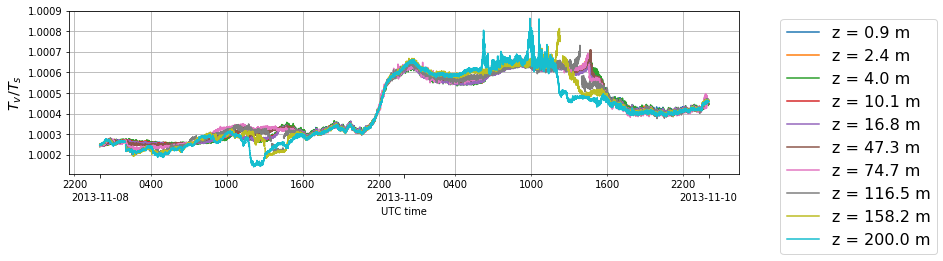

In [22]:
fig,ax = plot_timehistory_at_height(df.reset_index(1), 'Tv/Ts', heights)
ax.ticklabel_format(axis='y',useOffset=False)
ax.set_ylabel(r'$T_v/T_s$', fontsize='x-large')

### estimate $\theta_v$ from $T_s$
to get high-frequency data

In [23]:
df['thetas'] = df['Ts'] * (1000./df['p'])**0.286

### calculate some stats

In [24]:
df_10min = df.unstack().resample('10min').mean().stack()
df_10min['wdir'] = 180./np.pi * np.arctan2(-df_10min['u'], -df_10min['v'])
df_10min.loc[df_10min['wdir'] < 0, 'wdir'] += 360.

In [25]:
df_10min['uw'] = covariance(df['u'], df['w'], '10min', resample=True)
df_10min['vw'] = covariance(df['v'], df['w'], '10min', resample=True)

In [26]:
df_10min['hflux'] = covariance(df['Ts'],df['w'], '10min', resample=True)
df_10min['hflux_pot'] = covariance(df['thetas'],df['w'], '10min', resample=True)

In [28]:
df_10min_var = df.unstack().resample('10min').var().stack()

derived quantities

In [29]:
ang = np.arctan2(df_10min['v'], df_10min['u'])

In [30]:
df_10min['TIdir'] = np.sqrt(
    df_10min_var['u'] * np.cos(ang)**2
    + covariance(df['u'], df['v'], '10min', resample=True) * 2*np.sin(ang)*np.cos(ang)
    + df_10min_var['v'] * np.sin(ang)**2
)
df_10min['TIdir'] /= df_10min['wspd']

In [31]:
df_10min['TI'] = np.sqrt(df_10min_var['wspd']) / df_10min['wspd']

In [32]:
df_10min['k'] = 0.5 * (df_10min_var['u'] + df_10min_var['v'] + df_10min_var['w'])

In [33]:
df_10min['u*'] = (df_10min['uw']**2 + df_10min['vw']**2)**0.25

### SANITY CHECK: reproduce plots from Figure 3.4 in MMC Year 2 Report (PNNL-26267)

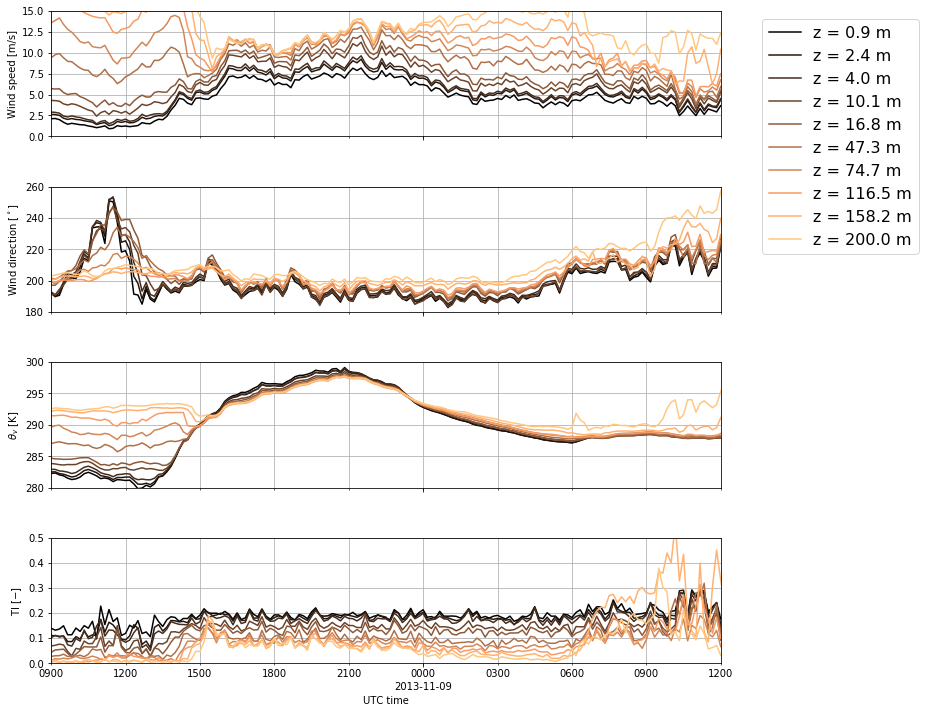

In [34]:
fig,ax = plot_timehistory_at_height(df_10min.reset_index(1),
                                    fields=['wspd','wdir','thetav','TI'],
                                    fieldlimits={
                                        'wspd':(0,15),
                                        'wdir':(180,260),
                                        'thetav':(280,300),
                                        'TI':(0,0.5),
                                    },
                                    timelimits=('2013-11-08 09:00','2013-11-09 12:00'),
                                    heights=heights,
                                    colormap='copper')
ax[3].xaxis.set_minor_locator(mdates.HourLocator(byhour=range(24),interval=3))

### estimate stability
Bulk Richardson number also plotted in Figure 3.4 of MMC Year 2 report

In [35]:
# selected stations, from report
z0,z1 = [2.4, 10.1]
dz = z1 - z0
z0,z1,dz

(2.4, 10.1, 7.699999999999999)

In [36]:
df0 = df_10min.xs(z0, level='height')
df1 = df_10min.xs(z1, level='height')

In [37]:
Tv_mean = 0.5*(df0['Tv'] + df1['Tv'])

In [38]:
bulk_Ri = 9.81/Tv_mean * (df1['thetav'] - df0['thetav']) * dz \
        / ((df1['u']-df0['u'])**2 + (df1['v']-df0['v'])**2)

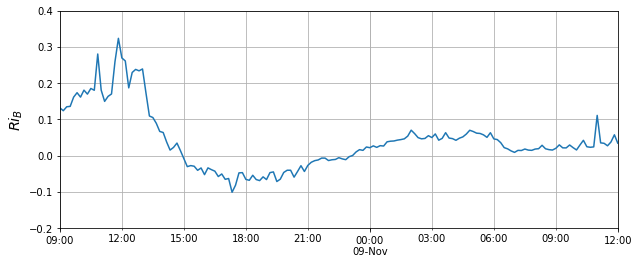

In [39]:
fig,ax = plt.subplots(figsize=(10,4))
bulk_Ri.plot()
ax.set_xlabel('')
ax.set_ylabel('$Ri_B$', fontsize='x-large')
ax.set_xlim(('2013-11-08 09:00','2013-11-09 12:00'))
ax.set_ylim((-0.2, 0.4))
ax.grid(which='both')

In [40]:
df_10min['L'] = -df_10min['u*']**3 * df_10min['Tv'] / (0.4 * 9.81 * df_10min['hflux'])
for z in heights:
    df_10min.loc[(slice(None),z), 'z/L'] = z / df_10min.loc[(slice(None),z), 'L']

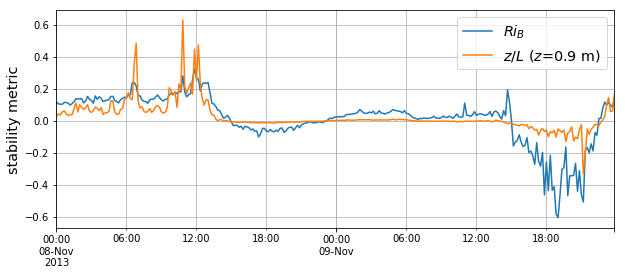

In [41]:
fig,ax = plt.subplots(figsize=(10,4))
bulk_Ri.plot(label=r'$Ri_B$')
for z in heights[:1]:
    z_L = df_10min.xs(z,level='height')['z/L']
    z_L.plot(label=r'$z/L$ ($z$={:g} m)'.format(z))
ax.set_xlabel('')
ax.set_ylabel('stability metric',fontsize='x-large')
ax.grid(which='both')
ax.legend(fontsize='x-large')

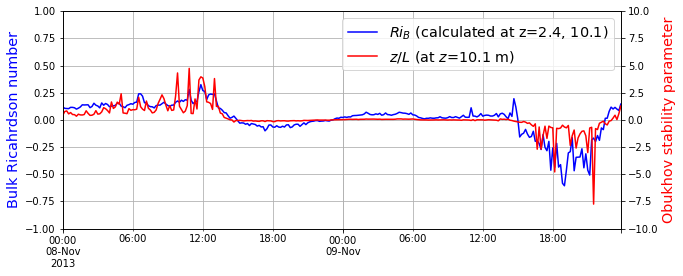

In [42]:
fig,ax = plt.subplots(figsize=(10,4))
bulk_Ri.plot(color='b')
ax.set_ylim((-1,1))
ax.set_xlabel('')
ax.set_ylabel('Bulk Ricahrdson number',fontsize='x-large')
ax.yaxis.label.set_color('b')

ax2 = ax.twinx()
for z in [10.1]:
    z_L = df_10min.xs(z,level='height')['z/L']
    z_L.plot(color='r'.format(z))
ax2.set_ylim((-10,10))
ax2.set_ylabel('Obukhov stability parameter',fontsize='x-large')
ax2.yaxis.label.set_color('r')

ax.grid(which='both')

labels = [r'$Ri_B$ (calculated at z={:g}, {:g})'.format(z0,z1),
          r'$z/L$ (at $z$={:g} m)'.format(z)]
ax.legend([ax.get_lines()[0], ax2.get_lines()[0]], labels, fontsize='x-large')

## measured heat flux

In [43]:
# stable/unstable conditions
Ri_s = bulk_Ri.loc[bulk_Ri > 0]
Ri_u = bulk_Ri.loc[bulk_Ri <= 0]

In [44]:
surf = df_10min.xs(0.9, level='height')
hflux = surf['hflux']
hflux_pot = surf['hflux_pot']

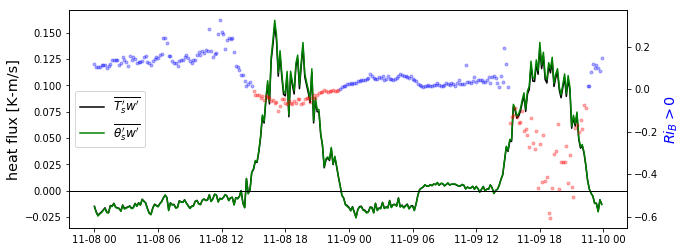

In [45]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(hflux.index, hflux, 'k', label=r"$\overline{T_s'w'}$")
ax.plot(hflux_pot.index, hflux_pot, 'g', label=r"$\overline{\theta_s'w'}$")
ax.legend(loc='center left',fontsize='large')
ax.set_xlabel('')
ax.set_ylabel('heat flux [K-m/s]', fontsize='x-large')
ax.axhline(0, color='k', lw=1)

ax2 = ax.twinx()
ax2.plot(Ri_u.index, Ri_u, 'r.', alpha=0.3)
ax2.plot(Ri_s.index, Ri_s, 'b.', alpha=0.3)
ax2.set_ylabel(r'$Ri_B > 0$', fontsize='x-large')
ax2.yaxis.label.set_color('b')